In [1]:
import os
import pandas as pd
import numpy as np
import requests
import json
import yfinance as yf
import seaborn as sns
from dotenv import load_dotenv
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
import sklearn.metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import datetime
from datetime import timedelta

In [2]:
# Load .env file
load_dotenv()

True

In [3]:
# Check if the environment variable is set for Open AI API
api_key = os.getenv("OPENAI_API_KEY")
if api_key is None:
    raise ValueError("The environment variable 'OPENAI_API_KEY' is not set.")

In [4]:
# Check if the environment variable is set for Vantage API
van_api_key = os.getenv("VANTAGE_API_KEY")
if van_api_key is None:
    raise ValueError("The environment variable 'VANTAGE_API_KEY' is not set.")

In [5]:
# Stock symbol for S&P 500
symbol = "SPY"

# API URL for real-time stock data
stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&outputsize=full&apikey={van_api_key}"

# Fetch stock data
response = requests.get(stock_url)

stock_data = response.json()

print(stock_data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'SPY', '3. Last Refreshed': '2025-03-20', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-20': {'1. open': '563.3300', '2. high': '570.5700', '3. low': '562.6012', '4. close': '565.4900', '5. volume': '62958195'}, '2025-03-19': {'1. open': '562.8300', '2. high': '570.9500', '3. low': '561.6300', '4. close': '567.1300', '5. volume': '66555985'}, '2025-03-18': {'1. open': '564.8000', '2. high': '565.0200', '3. low': '559.0600', '4. close': '561.0200', '5. volume': '66041422'}, '2025-03-17': {'1. open': '562.7900', '2. high': '569.7100', '3. low': '562.3500', '4. close': '567.1500', '5. volume': '49008709'}, '2025-03-14': {'1. open': '556.1100', '2. high': '563.8300', '3. low': '551.4917', '4. close': '562.8100', '5. volume': '62660321'}, '2025-03-13': {'1. open': '558.4900', '2. high': '559.1050', '3. low': '549.6800', '4. close': '551.4200', '

In [6]:
# Extract time series data
time_series = stock_data["Time Series (Daily)"]
# Prints daily stock price data
print(time_series)

{'2025-03-20': {'1. open': '563.3300', '2. high': '570.5700', '3. low': '562.6012', '4. close': '565.4900', '5. volume': '62958195'}, '2025-03-19': {'1. open': '562.8300', '2. high': '570.9500', '3. low': '561.6300', '4. close': '567.1300', '5. volume': '66555985'}, '2025-03-18': {'1. open': '564.8000', '2. high': '565.0200', '3. low': '559.0600', '4. close': '561.0200', '5. volume': '66041422'}, '2025-03-17': {'1. open': '562.7900', '2. high': '569.7100', '3. low': '562.3500', '4. close': '567.1500', '5. volume': '49008709'}, '2025-03-14': {'1. open': '556.1100', '2. high': '563.8300', '3. low': '551.4917', '4. close': '562.8100', '5. volume': '62660321'}, '2025-03-13': {'1. open': '558.4900', '2. high': '559.1050', '3. low': '549.6800', '4. close': '551.4200', '5. volume': '74079414'}, '2025-03-12': {'1. open': '562.1700', '2. high': '563.1100', '3. low': '553.6900', '4. close': '558.8700', '5. volume': '69588167'}, '2025-03-11': {'1. open': '559.4000', '2. high': '564.0200', '3. low

In [7]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(time_series, orient="index")
df

,1. open,2. high,3. low,4. close,5. volume
2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195
2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985
2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422
2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709
2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [8]:
# Rename columns for readability
df.columns = ["open", "high", "low", "close", "volume"]
df

,open,high,low,close,volume
2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195
2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985
2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422
2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709
2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321
...,...,...,...,...,...
1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500
1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500
1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300
1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6385 entries, 2025-03-20 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    6385 non-null   object
 1   high    6385 non-null   object
 2   low     6385 non-null   object
 3   close   6385 non-null   object
 4   volume  6385 non-null   object
dtypes: object(5)
memory usage: 299.3+ KB


In [10]:
# Convert data types
df = df.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6385 entries, 2025-03-20 to 1999-11-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    6385 non-null   float64
 1   high    6385 non-null   float64
 2   low     6385 non-null   float64
 3   close   6385 non-null   float64
 4   volume  6385 non-null   float64
dtypes: float64(5)
memory usage: 299.3+ KB


In [12]:
# Reset index to make the date a column
df = df.reset_index()

In [13]:
# Rename the new column to "date" (if it’s not automatically named)
df = df.rename(columns={"index": "date"})
df

,date,open,high,low,close,volume
0,2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195.0
1,2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985.0
2,2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422.0
3,2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709.0
4,2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321.0
...,...,...,...,...,...,...
6380,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6381,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6382,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6383,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [14]:
# Convert to datetime format (recommended)
df["date"] = pd.to_datetime(df["date"])

# Display the DataFrame
df

,date,open,high,low,close,volume
0,2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195.0
1,2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985.0
2,2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422.0
3,2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709.0
4,2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321.0
...,...,...,...,...,...,...
6380,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6381,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6382,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6383,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6385 entries, 0 to 6384
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6385 non-null   datetime64[ns]
 1   open    6385 non-null   float64       
 2   high    6385 non-null   float64       
 3   low     6385 non-null   float64       
 4   close   6385 non-null   float64       
 5   volume  6385 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 299.4 KB


In [16]:
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [17]:
df.describe()

,date,open,high,low,close,volume
count,6385,6385.000000,6385.000000,6385.000000,6385.000000,6.385000e+03
mean,2012-07-10 07:15:29.741581824,213.767423,215.006769,212.403137,213.777130,1.049006e+08
min,1999-11-01 00:00:00,67.950000,70.000000,67.100000,68.110000,1.708170e+05
25%,2006-03-09 00:00:00,120.600000,121.330000,119.930000,120.660000,4.945526e+07
50%,2012-07-10 00:00:00,149.490000,150.375000,148.437500,149.480000,7.794072e+07
75%,2018-11-09 00:00:00,277.190000,278.900000,275.470000,277.370000,1.336267e+08
max,2025-03-20 00:00:00,611.540000,613.230000,609.560000,612.930000,8.710263e+08
std,NaN,127.779914,128.362292,127.114027,127.793961,9.072530e+07


In [18]:
# Correlation between the variable
corr_matrix = df[['open', 'high', 'low', 'close', 'volume']].corr()
corr_matrix

,open,high,low,close,volume
open,1.000000,0.999943,0.999923,0.999869,-0.209229
high,0.999943,1.000000,0.999881,0.999919,-0.206836
low,0.999923,0.999881,1.000000,0.999931,-0.212689
close,0.999869,0.999919,0.999931,1.000000,-0.210100
volume,-0.209229,-0.206836,-0.212689,-0.210100,1.000000


<Axes: >

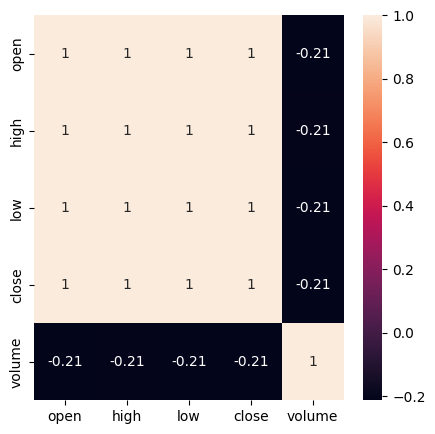

In [19]:
# Visualize the correlation matrix
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix, annot=True)

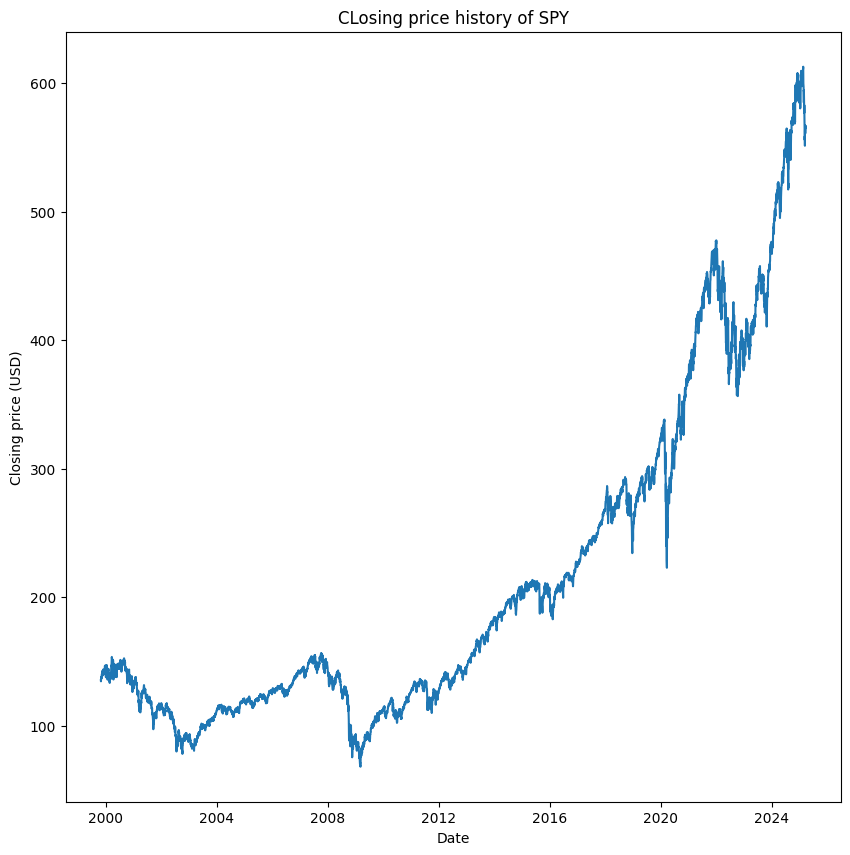

In [20]:
# Visualization of the closing price and the date
plt.figure(figsize=(10,10))
plt.title('CLosing price history of SPY')
plt.plot(df['date'], df['close'])
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.show()

In [21]:
df.head()

,date,open,high,low,close,volume
0,2025-03-20,563.33,570.57,562.6012,565.49,62958195.0
1,2025-03-19,562.83,570.95,561.6300,567.13,66555985.0
2,2025-03-18,564.80,565.02,559.0600,561.02,66041422.0
3,2025-03-17,562.79,569.71,562.3500,567.15,49008709.0
4,2025-03-14,556.11,563.83,551.4917,562.81,62660321.0


In [22]:
imputer = SimpleImputer(missing_values=np.nan)  # Handling missing values
df1 = df.drop(columns=['date'])
df1 = pd.DataFrame(imputer.fit_transform(df1), columns=df1.columns)
df1 = df1.reset_index(drop=True)
# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df1.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(df1.columns))
target_scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled[['open', 'close']] = target_scaler.fit_transform(df1[['open', 'close']].to_numpy())
df_scaled = df_scaled.astype(float)

In [23]:
# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['open', 'close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)

In [24]:
# Dataset splitting
SPLIT = 0.85
(xVal, yVal) = singleStepSampler(df_scaled, 20)
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

In [25]:

# Define the model
multivariate_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(2)
])

# Compile the model
multivariate_lstm.compile(optimizer='adam', loss='mse')



/Users/tes/.pyenv/versions/3.12.6/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
history = multivariate_lstm.fit(X_train, y_train, epochs=20, verbose=1)

Epoch 1/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0339
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.9896e-05
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.3605e-05
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0939e-05
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8829e-05
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6520e-05
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5958e-05
Epoch 8/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3064e-05
Epoch 9/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2103e-05
Epoch 10/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9728e-05
Epoch 11/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6562e-05
Epoch 12/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0131e-05
Epoch 13/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1880e-05
Epoch 14/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8995e-05
Epoch

In [27]:
df

,date,open,high,low,close,volume
0,2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195.0
1,2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985.0
2,2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422.0
3,2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709.0
4,2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321.0
...,...,...,...,...,...,...
6380,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6381,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6382,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6383,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [28]:
# Reload the data with the date index
df2 = df  

In [29]:
df2

,date,open,high,low,close,volume
0,2025-03-20,563.3300,570.5700,562.6012,565.4900,62958195.0
1,2025-03-19,562.8300,570.9500,561.6300,567.1300,66555985.0
2,2025-03-18,564.8000,565.0200,559.0600,561.0200,66041422.0
3,2025-03-17,562.7900,569.7100,562.3500,567.1500,49008709.0
4,2025-03-14,556.1100,563.8300,551.4917,562.8100,62660321.0
...,...,...,...,...,...,...
6380,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6381,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6382,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6383,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [30]:
df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

df2.head()

,open,high,low,close,volume
date,,,,,
2025-03-20,563.33,570.57,562.6012,565.49,62958195.0
2025-03-19,562.83,570.95,561.6300,567.13,66555985.0
2025-03-18,564.80,565.02,559.0600,561.02,66041422.0
2025-03-17,562.79,569.71,562.3500,567.15,49008709.0
2025-03-14,556.11,563.83,551.4917,562.81,62660321.0


In [31]:
df2 .columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


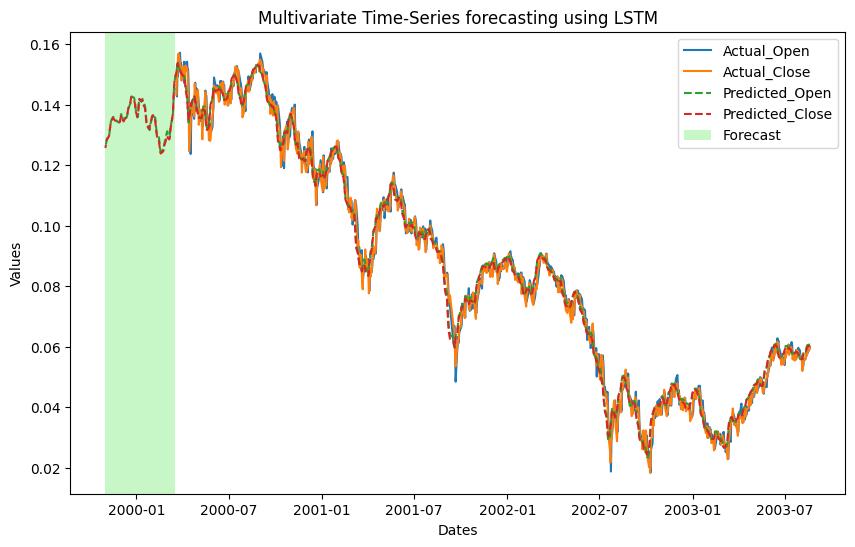

In [32]:


# Forecast Plot with Dates on X-axis
predicted_values = multivariate_lstm.predict(X_test)

d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test[:, 0],
    'Actual_Close': y_test[:, 1],
}

d = pd.DataFrame(d)
d.index = df2.index[-len(y_test):]  # Assigning the correct date index

fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(d) * 0.9)  
highlight_end = len(d) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])

# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')

# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')

plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

In [33]:
 # Model Evaluation Function
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'RMSE': sklearn.metrics.root_mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }

# Dictionary to Store Results
result = {}

for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)

print(result)


{'Predicted_Open': {'MSE': 1.8550797602721663e-05, 'RMSE': 0.0043070636868662235, 'MAE': 0.0033340330909475352, 'R2': 0.9880245928968253}, 'Predicted_Close': {'MSE': 1.3839268082879647e-05, 'RMSE': 0.0037201166759766617, 'MAE': 0.0028432374743961038, 'R2': 0.990963832708808}}
